import packages & selct dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial

fold_path = 'C:\\Users\\schle\Documents\\GitHub\\Incubator-2022-Geometry-of-Color\\CSV data all OCT locs Jan 2022\\'

subject = 'AO001R'; # 'AO001R', 'AO008R'
angle = 'temporal' # 'temporal', 'nasal', 'superior', 'inferior'
eccentricity = 1.5; # 1.5, 4, 10

coord_fltype = '.csv'
img_fltype = '.png'

conetype_ids = ['L','M','S','all']
conetype_colors = ['r','g','b','y']
conetype_sizes = [10, 10, 10, 30]

bin_width = 5; #pixels
num_mc = 100; # number of monte carlo mosaics to generate

load in coordinate data and image

In [2]:
prefix = subject + '_' + angle + '_' + str(eccentricity) #convention of filenames

coords = {} #store 2D arrays of each mosaic type
num_type = {}

#load in cone coordinates (relative to ROI lower left corner)
for cone_type in conetype_ids:
    coords[cone_type] = np.loadtxt(fold_path + prefix + '_' + cone_type + coord_fltype, delimiter=',')
    num_type[cone_type] = coords[cone_type][:,0].size
    
#load in ROI image
raw_img = plt.imread(fold_path + prefix + '_raw' + img_fltype);
ROI_x = raw_img.shape[1]
ROI_y = raw_img.shape[0]

plot cones on the image 

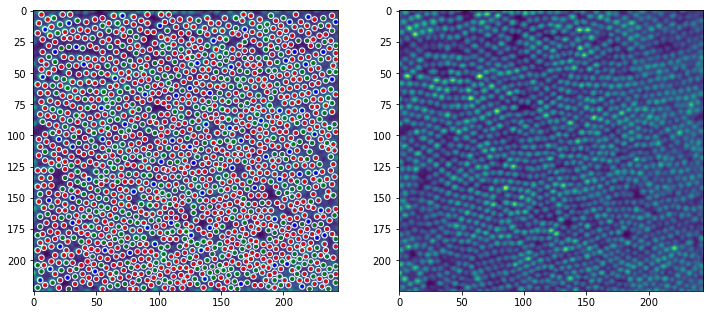

In [3]:
#plot the ROI, then outline all classed cones in yellow and fill in with their respective cone type 
fig, ((ax0, ax1)) = plt.subplots(1,2)
fig.set_size_inches(12,6)

#overlay cone coordinates on the image
ax0.imshow(raw_img)
for ind,cone_type in enumerate(conetype_ids):
    #outline all cones in the 'all' mosaic in white
    if cone_type == 'all':
        csize = 30
        cface = 'none'
        cedge = 'w'
    else: # for 'L', 'M', and 'S' mosaics plot all cones in solid circles of their respective color
        csize = 10
        cface = conetype_colors[ind]
        cedge = 'none'    
    ax0.scatter(x=coords[cone_type][:,0], y=coords[cone_type][:,1], s=csize, facecolors=cface,edgecolors=cedge)
    
#show the plain image
ax1.imshow(raw_img)


function for initializing a quad of figures

In [4]:
def quad_fig(size):
    """
    initialize 2x2 figure.  input: size = [x,y] in inches
    """
    
    fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(2,2)
    axes = [ax0,ax1,ax2,ax3]
    fig.set_size_inches(size[0],size[1])
    fig.tight_layout()
    
    return axes,fig

function for plotting quad of scatter plots

In [5]:
def quad_coord(coord_dict,z_dim,unit,ids,colors):
    """
    """
    axes,fig = quad_fig([9,9])
    
    for ind,id_str in enumerate(ids): 
        
        if len(coord_dict[id_str].shape) == 2:    # 2D COORDINATE ARRAY
            scatter_x = coord_dict[id_str][:,0]
            scatter_y = coord_dict[id_str][:,1]
            
        else: #3D COORDINATE ARRAY
            scatter_x = coord_dict[id_str][:,0,z_dim]
            scatter_y = coord_dict[id_str][:,1,z_dim]
            
        axes[ind].scatter(x = scatter_x, y = scatter_y,
                     s = 10,
                     facecolors=colors[ind],
                     edgecolors='none') 
        axes[ind].set_xlabel('distance (' + unit +')')
        axes[ind].set_title(id_str)
        axes[ind].set_ylabel('cones per ' + str(bin_width) + unit + ' bin')
        axes[ind].set_aspect('equal')
    
    return axes

In [6]:
def quad_scat(x_dict,y_dict,z_dim,unit,ids,colors):
    """
    """
    axes,fig = quad_fig([9,9])
    
    for ind,id_str in enumerate(ids): 
        
        if len(y_dict[id_str].shape) == 1:    # 2D COORDINATE ARRAY
            scatter_x = x_dict[id_str]
            scatter_y = y_dict[id_str]
            
        else: #3D COORDINATE ARRAY
            for z in z_dim:
                scatter_x = x_dict[id_str]
                scatter_y = y_dict[id_str][:,z]
                
                axes[ind].scatter(x = scatter_x, y = scatter_y,
                     s = 10,
                     facecolors=colors[ind],
                     edgecolors='none') 
            
        axes[ind].scatter(x = scatter_x, y = scatter_y,
                     s = 10,
                     facecolors=colors[ind],
                     edgecolors='none') 
        axes[ind].set_xlabel('distance (' + unit +')')
        axes[ind].set_title(id_str)
        axes[ind].set_ylabel('cones per ' + str(bin_width) + unit + ' bin')
    
    
    
    
    return axes, fig

plot the cone mosaic types

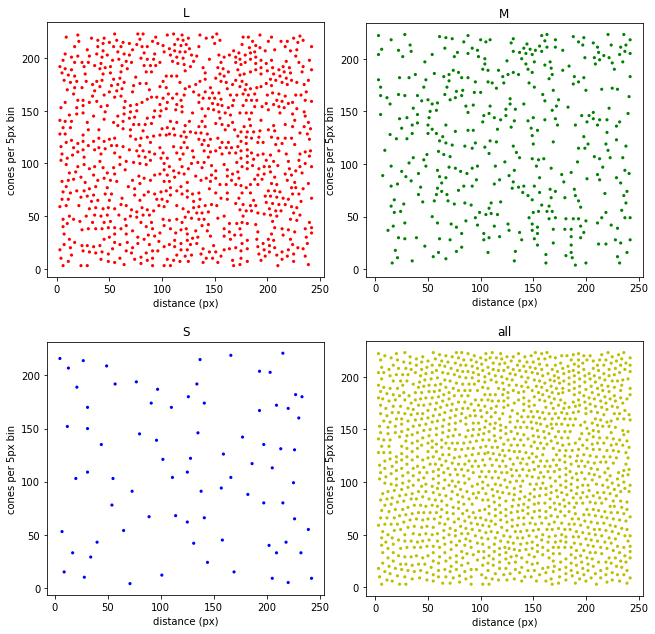

In [7]:
axes = quad_coord(coords,0,'px',conetype_ids,conetype_colors)

function that returns a [num_cones,num_cones] shaped matrix of intercone distances and a vectorized sorted version of the same matrix. size of dim [2] of square matrix and dim [1] of vector will = size of dim [2] of the coordinate array input, so the operation can be performed on a "stack" of cone coordinates.

In [8]:
def dist_matrices(coords):
    numzeros = coords.shape[0]
    if len(coords.shape) == 2:    # 1 COORDINATE ARRAY
    
        #2D array of every cone in the mosaic's distance from every other cone
        dist_square = spatial.distance_matrix(coords,coords)
        
        #turn ^ into a vector
        temp = np.reshape(dist_square[:,:], -1)
    
        #sort the vector
        dist_vect = np.sort(temp) 
        
        findzeros = np.nonzero(dist_vect==0)[0].size
        
        if numzeros != findzeros:
            print('ERROR: bad logic about distance = 0. lreal num zeros is ', findzeros , ', expected ', numzeros)
        dist_vect = dist_vect[numzeros+1:]    

        
    else:    # >1 COORDINATE ARRAY 
    
        #initialize 3D array for stack of square distance matrices and 2D array for columns of sorted cone distances
        dist_square = np.zeros([coords.shape[0],coords.shape[0],coords.shape[2]])
        dist_vect = np.zeros([pow(coords.shape[0],2),coords.shape[2]])
        
        for z in np.arange(0,coords.shape[2]):
        
            # fill w stack of 2D arrays of intercone distances
            dist_square[:,:,z] = spatial.distance_matrix(coords[:,:,z],coords[:,:,z])

            #turn ^ into 2D array with every column being an array of distances
            temp = np.reshape(dist_square[:,:,z], -1)

            #sort the vectors
            dist_vect[:,z] = np.sort(temp) 
            
        #remove zeros
        findzeros = np.nonzero(dist_vect[:,z]==0)[0].size
        if numzeros != findzeros:
            print('ERROR: bad logic about distance = 0. real # zeros is ', findzeros , ', expected ', numzeros)
        dist_vect = dist_vect[numzeros+1:,:]    

    return dist_square, dist_vect


calculate matrix of intercone distances for all cones, L-cones, M-cones, and S-cones

In [9]:
dists = {}
dists_sorted = {}

for cone_type in conetype_ids:
    #2D vector of every cone in the mosaic's distance from every other cone
    dists[cone_type], dists_sorted[cone_type] = dist_matrices(coords[cone_type])

function for plotting quad of histograms for the four cone types

In [10]:
def quad_hist(hist_dict,bin_edges,unit,ids,colors,x_dim):
    """
    """
    axes,fig = quad_fig([9,9])
        
    # plot histogram of intercone distances for each mosaic
    for  ind,id_str in enumerate(ids):
        if len(hist_dict[id_str].shape)==1:
            hist_data = hist_dict[id_str]
        else:
            hist_data = hist_dict[id_str][:,x_dim]
            
        axes[ind].hist(hist_data, 
                    bins=bin_edges[id_str],
                    color = colors[ind])
        axes[ind].set_xlabel('distance ('+ unit + ')')
        axes[ind].set_title(id_str)
        axes[ind].set_ylabel('cones per ' + str(bin_width) + unit + ' bin')   
        
    return axes

calculate bin stuff

In [11]:
def quad_plot(x, plot_dict,unit,ids,colors):
    axes,fig = quad_fig([9,9])
    
    for ind,id_str in enumerate(ids):
        axes[ind].plot(x[id_str],plot_dict[id_str],color=colors[ind])
        axes[ind].set_title(id_str)
        
    return axes,fig

In [12]:
bin_edges = {}
num_bins = {}

for  ind,cone_type in enumerate(conetype_ids):
    #bin edges from 0 to the largest inter-cone distance
    bin_edges[cone_type] = np.arange(1, int(max(dists_sorted[cone_type]) + bin_width), bin_width)
    num_bins[cone_type] = bin_edges[cone_type].size-1

In [13]:
plot_x = {}
for conetype in conetype_ids:
    plot_x[conetype] = bin_edges[conetype][1:]/2

In [14]:
#plot the bin annuli around a cone at ROI corner

calculate area of each bin/annulus (irrespective of edge effects)

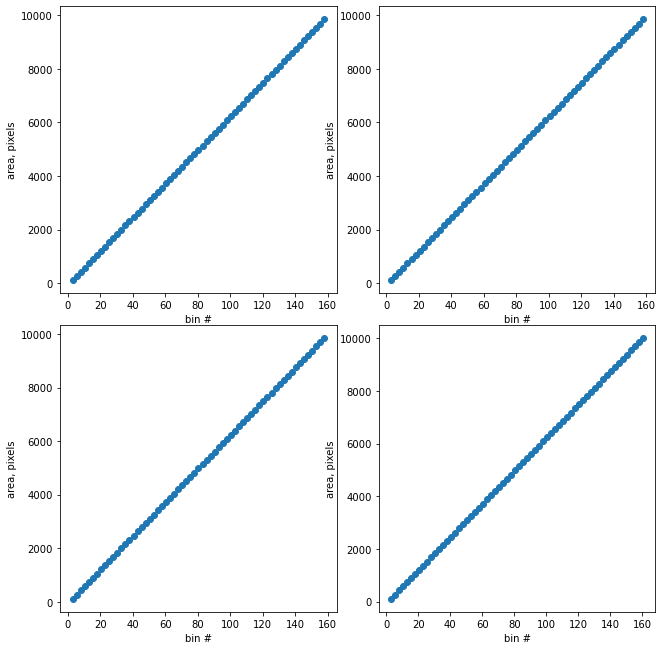

In [15]:
bin_area = {};
axes, fig = quad_fig([9,9])

for ind,cone_type in enumerate(conetype_ids):
    bin_area[cone_type] = [];
    for ind2,edge in enumerate(bin_edges[cone_type]):
        if ind2 < bin_edges[cone_type].size-1:
            outer_rad = bin_edges[cone_type][ind2+1]
            bin_area[cone_type].append(np.pi * (np.power(bin_edges[cone_type][ind2+1],2) - np.power(edge,2)))

    axes[ind].scatter(plot_x[cone_type],bin_area[cone_type])
    axes[ind].set_xlabel('bin #')
    axes[ind].set_ylabel('area, pixels')

plot histograms of intercone distances

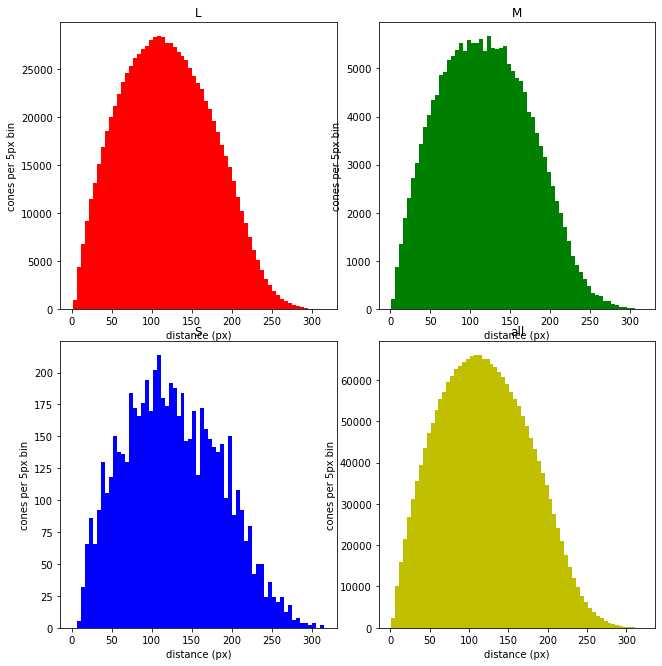

In [16]:
axes = quad_hist(dists_sorted,bin_edges,'px',conetype_ids,conetype_colors,0)

function to generate array of monte carlo shuffled points distributed uniformly within a 2D range

In [17]:
def MonteCarlo_uniform(num_mc,num_coords,xlim,ylim):
    """ 
    """
    # [0] = cone index, [1] = (x,y), [2] = Monte Carlo trial
    mc_coords = np.zeros([num_coords,2,num_mc])
    
    # randomly sample coordinates from a uniform distribution of the the ROI space
    mc_coords[:,0,:] = np.random.uniform(low=xlim[0],high=xlim[1], size=(num_coords,num_mc))
    mc_coords[:,1,:] = np.random.uniform(low=ylim[0],high=ylim[1], size=(num_coords,num_mc))
    
    return(mc_coords)
    


generate monte carlo shuffles of the 3 cone-type sub-mosaics as well as the total mosaic

In [18]:
mc_coords = {}

for ind,cone_type in enumerate(conetype_ids):
    ncones = num_type[cone_type]
    
    #generate Monte Carlo mosaics
    mc_coords[cone_type] = MonteCarlo_uniform(num_mc,num_type[cone_type],[0,ROI_x],[0,ROI_y])  

View one set of monte carlo coordinates

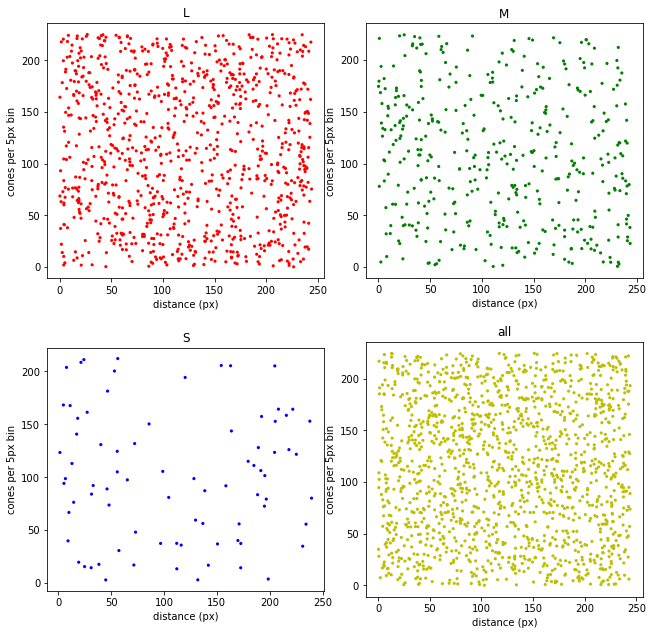

In [19]:
mc_ind = 0
axes = quad_coord(mc_coords,[mc_ind],'px',conetype_ids,conetype_colors)

calculate distances between all cone types of the Monte Carlo shuffles

In [20]:
mc_dists = {}
mc_dists_sorted = {}
for ind,cone_type in enumerate(conetype_ids): 
    #calculate 
    mc_dists[cone_type],mc_dists_sorted[cone_type] = dist_matrices(mc_coords[cone_type])

Show histogram of one set of Monte Carlo distances

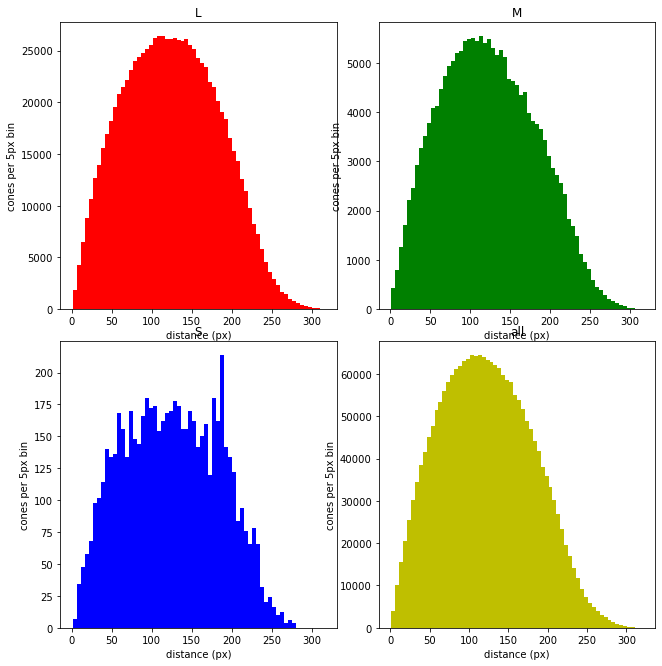

In [21]:
axes = quad_hist(mc_dists_sorted,bin_edges,'px',conetype_ids,conetype_colors,0)

get distribution of all monte carlo distance histograms as a matrix

In [22]:
mc_hists = {}

for cone_type in conetype_ids:
    mc_hists[cone_type] = np.zeros([num_bins[cone_type],num_mc])
    for mc in np.arange(0,num_mc):
        mc_hists[cone_type][:,mc], edges = np.histogram(mc_dists_sorted[cone_type][:,mc], bins=bin_edges[cone_type])


In [23]:
def quad_stats(x,plot_dict,xstd,unit,ids,colors):
    axes,fig = quad_fig([9,9])
    
    mean = {}
    std = {}
    
    for ind,id_str in enumerate(ids):
            mean[id_str] = plot_dict[id_str].mean(1)
            std[id_str] = plot_dict[id_str].std(1)
            
            axes[ind].set_facecolor('k')
            
            axes[ind].plot(x[id_str],mean[id_str],color=colors[ind])
            
            err_high = mean[id_str]+(std[id_str]*xstd)
            err_low = mean[id_str]-(std[id_str]*xstd)
            
            axes[ind].fill_between(x[id_str],err_low,err_high,color=colors[ind],alpha=.5)
            
            axes[ind].set_title(id_str)
                           
    return [axes, fig, mean, std]

plot mc hist distribution

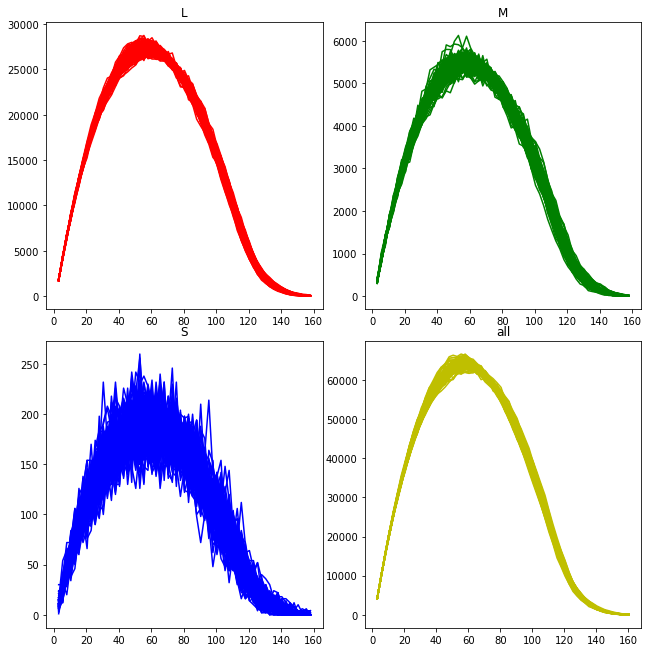

In [24]:
axes,fig = quad_plot(plot_x,mc_hists,'px',conetype_ids,conetype_colors)

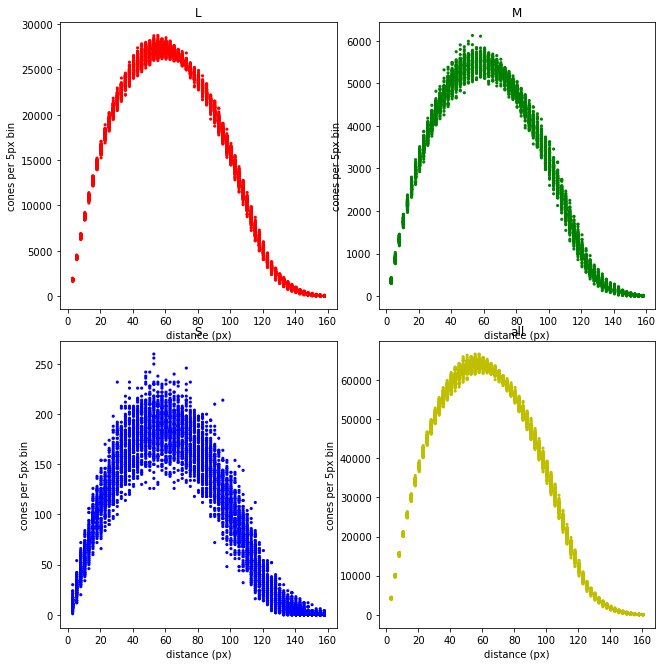

In [25]:
axes,fig = quad_scat(plot_x,mc_hists,np.arange(0,num_mc),'px',conetype_ids,conetype_colors)

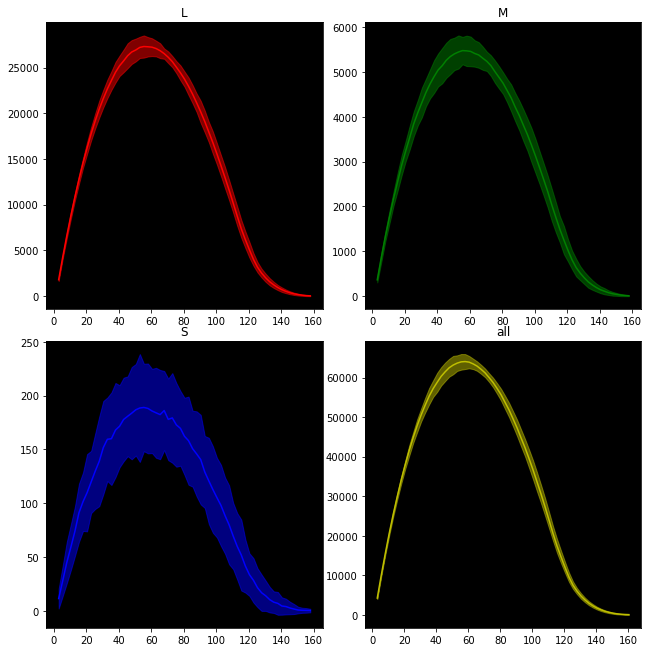

In [26]:
axes, fig, mc_mean,mc_std = quad_stats(plot_x,mc_hists,2,'px',conetype_ids,conetype_colors)

In [27]:
true_hist = {}

for cone_type in conetype_ids:
    true_hist[cone_type], edges = np.histogram(dists_sorted[cone_type], bins=bin_edges[cone_type])

Overlain true and monte carlo distance histograms

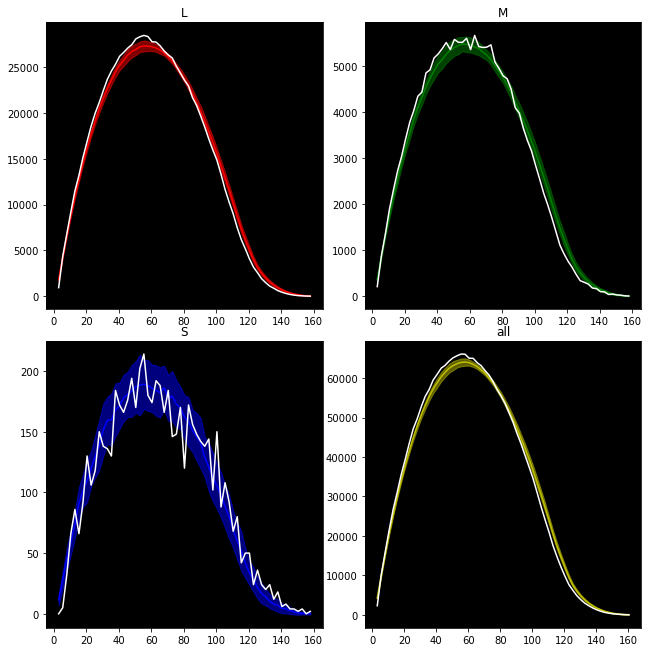

In [28]:
[axes,fig,mc_mean,mc_std] = quad_stats(plot_x,mc_hists,1,'px',conetype_ids,conetype_colors)

for ind,cone_type in enumerate(conetype_ids):
   axes[ind].plot(plot_x[cone_type],true_hist[cone_type],'w')

normalize real and monte carlo by area (effectively becomes a density measurement impaired by edge effects)

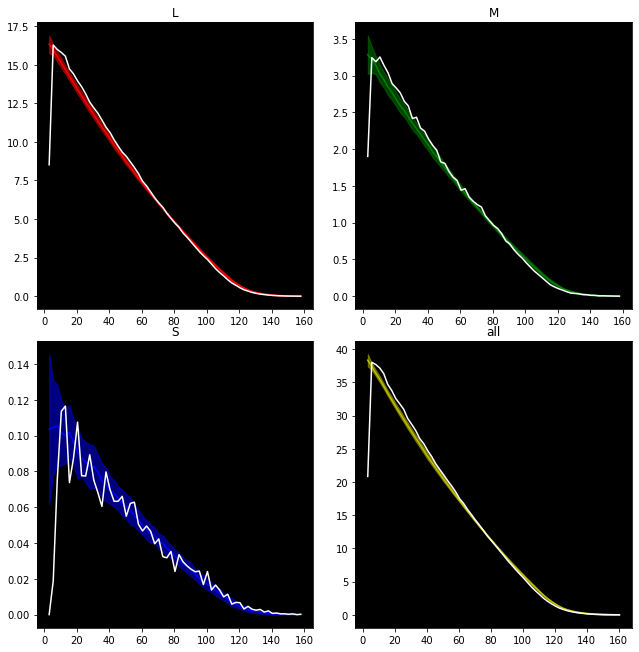

In [35]:
truehist_normed = {}
mchist_normed = {}

for cone_type in conetype_ids:
    truehist_normed[cone_type] = true_hist[cone_type] / bin_area[cone_type]
    mchist_normed[cone_type] = np.zeros([num_bins[cone_type],num_mc])
    for mc in np.arange(0,num_mc):
        mchist_normed[cone_type][:,mc] = mc_hists[cone_type][:,mc] / bin_area[cone_type]

[axes,fig,mc_normed_mean,mc_normed_std] = quad_stats(plot_x,mchist_normed,1,'px',conetype_ids,conetype_colors)

for ind,cone_type in enumerate(conetype_ids):
   axes[ind].plot(plot_x[cone_type],truehist_normed[cone_type],'w')

normalize by the monte carlo mean

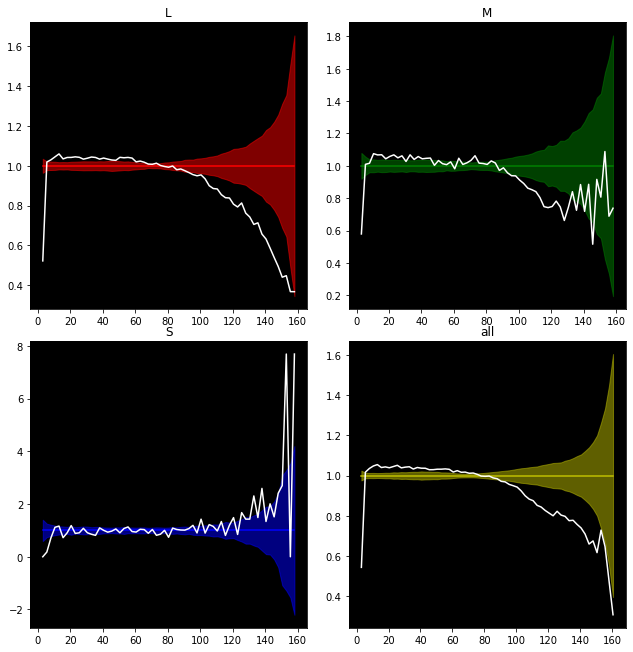

In [36]:
truehist_areamcnormed = {}
mchist_areamcnormed = {}

for cone_type in conetype_ids:
    truehist_areamcnormed[cone_type] = truehist_normed[cone_type] / mc_normed_mean[cone_type]
    mchist_areamcnormed[cone_type] = np.zeros([num_bins[cone_type],num_mc])
    for mc in np.arange(0,num_mc):
        mchist_areamcnormed[cone_type][:,mc] = mchist_normed[cone_type][:,mc] / mc_normed_mean[cone_type]

[axes,fig,mc_mcnormed_mean,mc_mcnormed_std] = quad_stats(plot_x,mchist_areamcnormed,1,'px',conetype_ids,conetype_colors)

for ind,cone_type in enumerate(conetype_ids):
   axes[ind].plot(plot_x[cone_type],truehist_areamcnormed[cone_type],'w')